# GraphRAG: Graph-Enhanced Retrieval-Augmented Generation

## Overview

GraphRAG is an advanced question-answering system that combines the power of graph-based knowledge representation with retrieval-augmented generation. It processes input documents to create a rich knowledge graph, which is then used to enhance the retrieval and generation of answers to user queries. The system leverages natural language processing, machine learning, and graph theory to provide more accurate and contextually relevant responses.

## Motivation

Traditional retrieval-augmented generation systems often struggle with maintaining context over long documents and making connections between related pieces of information. GraphRAG addresses these limitations by:

1. Representing knowledge as an interconnected graph, allowing for better preservation of relationships between concepts.
2. Enabling more intelligent traversal of information during the query process.
3. Providing a visual representation of how information is connected and accessed during the answering process.

## Key Components

1. **DocumentProcessor**: Handles the initial processing of input documents, creating text chunks and embeddings.

2. **KnowledgeGraph**: Constructs a graph representation of the processed documents, where nodes represent text chunks and edges represent relationships between them.

3. **QueryEngine**: Manages the process of answering user queries by leveraging the knowledge graph and vector store.

4. **Visualizer**: Creates a visual representation of the graph and the traversal path taken to answer a query.

## Method Details

1. **Document Processing**:
   - Input documents are split into manageable chunks.
   - Each chunk is embedded using a language model.
   - A vector store is created from these embeddings for efficient similarity search.

2. **Knowledge Graph Construction**:
   - Graph nodes are created for each text chunk.
   - Concepts are extracted from each chunk using a combination of NLP techniques and language models.
   - Extracted concepts are lemmatized to improve matching.
   - Edges are added between nodes based on semantic similarity and shared concepts.
   - Edge weights are calculated to represent the strength of relationships.

3. **Query Processing**:
   - The user query is embedded and used to retrieve relevant documents from the vector store.
   - An initial context is created from these retrieved documents.
   - The system checks if the current context provides a complete answer.
   - If the answer is incomplete, the context is expanded by traversing the knowledge graph.
   - Graph traversal is guided by edge weights and shared concepts.
   - The process of context expansion and completeness checking is repeated until a satisfactory answer is found or no more relevant information is available.

4. **Visualization**:
   - The knowledge graph is visualized with nodes representing text chunks and edges representing relationships.
   - Edge colors indicate the strength of relationships (weights).
   - The traversal path taken to answer a query is highlighted with curved, dashed arrows.
   - Start and end nodes of the traversal are distinctly colored for easy identification.

## Benefits of This Approach

1. **Improved Context Awareness**: By representing knowledge as a graph, the system can maintain better context and make connections across different parts of the input documents.

2. **Enhanced Retrieval**: The graph structure allows for more intelligent retrieval of information, going beyond simple keyword matching.

3. **Explainable Results**: The visualization of the graph and traversal path provides insight into how the system arrived at its answer, improving transparency and trust.

4. **Flexible Knowledge Representation**: The graph structure can easily incorporate new information and relationships as they become available.

5. **Efficient Information Traversal**: The weighted edges in the graph allow the system to prioritize the most relevant information pathways when answering queries.

## Conclusion

GraphRAG represents a significant advancement in retrieval-augmented generation systems. By incorporating a graph-based knowledge representation and intelligent traversal mechanisms, it offers improved context awareness, more accurate retrieval, and enhanced explainability. The system's ability to visualize its decision-making process provides valuable insights into its operation, making it a powerful tool for both end-users and developers. As natural language processing and graph-based AI continue to evolve, systems like GraphRAG pave the way for more sophisticated and capable question-answering technologies.

<div style="text-align: center;">

<img src="../images/graph_rag.svg" alt="graph RAG" style="width:80%; height:auto;">
</div>

### Import relevant libraries

In [28]:
import networkx as nx
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.callbacks import get_openai_callback

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import sys
from dotenv import load_dotenv
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from typing import List, Tuple, Dict
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import spacy

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import numpy as np

from spacy.cli import download
from spacy.lang.en import English


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # Add the parent directory to the path sicnce we work with notebooks
from helper_functions import *
from evaluation.evalute_rag import *

# Load environment variables from a .env file
load_dotenv()

# Set the OpenAI API key environment variable
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

True

### Define the document processor class

In [31]:
# Define the DocumentProcessor class
class DocumentProcessor:
    def __init__(self):
        """
        Initializes the DocumentProcessor with a text splitter and OpenAI embeddings.
        
        Attributes:
        - text_splitter: An instance of RecursiveCharacterTextSplitter with specified chunk size and overlap.
        - embeddings: An instance of OpenAIEmbeddings used for embedding documents.
        """
        self.text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        self.embeddings = OpenAIEmbeddings()

    def process_documents(self, documents):
        """
        Processes a list of documents by splitting them into smaller chunks and creating a vector store.
        
        Args:
        - documents (list of str): A list of documents to be processed.
        
        Returns:
        - tuple: A tuple containing:
          - splits (list of str): The list of split document chunks.
          - vector_store (FAISS): A FAISS vector store created from the split document chunks and their embeddings.
        """
        splits = self.text_splitter.split_documents(documents)
        vector_store = FAISS.from_documents(splits, self.embeddings)
        return splits, vector_store

    def create_embeddings_batch(self, texts, batch_size=32):
        """
        Creates embeddings for a list of texts in batches.
        
        Args:
        - texts (list of str): A list of texts to be embedded.
        - batch_size (int, optional): The number of texts to process in each batch. Default is 32.
        
        Returns:
        - numpy.ndarray: An array of embeddings for the input texts.
        """
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            batch_embeddings = self.embeddings.embed_documents(batch)
            embeddings.extend(batch_embeddings)
        return np.array(embeddings)

    def compute_similarity_matrix(self, embeddings):
        """
        Computes a cosine similarity matrix for a given set of embeddings.
        
        Args:
        - embeddings (numpy.ndarray): An array of embeddings.
        
        Returns:
        - numpy.ndarray: A cosine similarity matrix for the input embeddings.
        """
        return cosine_similarity(embeddings)


### Define the knowledge graph class

In [51]:
# Define the Concepts class
class Concepts(BaseModel):
    concepts_list: List[str] = Field(description="List of concepts")

# Define the KnowledgeGraph class
class KnowledgeGraph:
    def __init__(self):
        """
        Initializes the KnowledgeGraph with a graph, lemmatizer, and NLP model.
        
        Attributes:
        - graph: An instance of a networkx Graph.
        - lemmatizer: An instance of WordNetLemmatizer.
        - concept_cache: A dictionary to cache extracted concepts.
        - nlp: An instance of a spaCy NLP model.
        - edges_threshold: A float value that sets the threshold for adding edges based on similarity.
        """
        self.graph = nx.Graph()
        self.lemmatizer = WordNetLemmatizer()
        self.concept_cache = {}
        self.nlp = self._load_spacy_model()
        self.edges_threshold = 0.8

    def build_graph(self, splits, llm, embedding_model):
        """
        Builds the knowledge graph by adding nodes, creating embeddings, extracting concepts, and adding edges.
        
        Args:
        - splits (list): A list of document splits.
        - llm: An instance of a large language model.
        - embedding_model: An instance of an embedding model.
        
        Returns:
        - None
        """
        self._add_nodes(splits)
        embeddings = self._create_embeddings(splits, embedding_model)
        self._extract_concepts(splits, llm)
        self._add_edges(embeddings)

    def _add_nodes(self, splits):
        """
        Adds nodes to the graph from the document splits.
        
        Args:
        - splits (list): A list of document splits.
        
        Returns:
        - None
        """
        for i, split in enumerate(splits):
            self.graph.add_node(i, content=split.page_content)

    def _create_embeddings(self, splits, embedding_model):
        """
        Creates embeddings for the document splits using the embedding model.
        
        Args:
        - splits (list): A list of document splits.
        - embedding_model: An instance of an embedding model.
        
        Returns:
        - numpy.ndarray: An array of embeddings for the document splits.
        """
        texts = [split.page_content for split in splits]
        return embedding_model.embed_documents(texts)

    def _compute_similarities(self, embeddings):
        """
        Computes the cosine similarity matrix for the embeddings.
        
        Args:
        - embeddings (numpy.ndarray): An array of embeddings.
        
        Returns:
        - numpy.ndarray: A cosine similarity matrix for the embeddings.
        """
        return cosine_similarity(embeddings)

    def _load_spacy_model(self):
        """
        Loads the spaCy NLP model, downloading it if necessary.
        
        Args:
        - None
        
        Returns:
        - spacy.Language: An instance of a spaCy NLP model.
        """
        try:
            return spacy.load("en_core_web_sm")
        except OSError:
            print("Downloading spaCy model...")
            download("en_core_web_sm")
            return spacy.load("en_core_web_sm")

    def _extract_concepts_and_entities(self, content, llm):
        """
        Extracts concepts and named entities from the content using spaCy and a large language model.
        
        Args:
        - content (str): The content from which to extract concepts and entities.
        - llm: An instance of a large language model.
        
        Returns:
        - list: A list of extracted concepts and entities.
        """
        if content in self.concept_cache:
            return self.concept_cache[content]
        
        # Extract named entities using spaCy
        doc = self.nlp(content)
        named_entities = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG", "GPE", "WORK_OF_ART"]]
        
        # Extract general concepts using LLM
        concept_extraction_prompt = PromptTemplate(
            input_variables=["text"],
            template="Extract key concepts (excluding named entities) from the following text:\n\n{text}\n\nKey concepts:"
        )
        concept_chain = concept_extraction_prompt | llm.with_structured_output(Concepts)
        general_concepts = concept_chain.invoke({"text": content}).concepts_list
        
        # Combine named entities and general concepts
        all_concepts = list(set(named_entities + general_concepts))
        
        self.concept_cache[content] = all_concepts
        return all_concepts

    def _extract_concepts(self, splits, llm):
        """
        Extracts concepts for all document splits using multi-threading.
        
        Args:
        - splits (list): A list of document splits.
        - llm: An instance of a large language model.
        
        Returns:
        - None
        """
        with ThreadPoolExecutor() as executor:
            future_to_node = {executor.submit(self._extract_concepts_and_entities, split.page_content, llm): i 
                              for i, split in enumerate(splits)}
            
            for future in tqdm(as_completed(future_to_node), total=len(splits), desc="Extracting concepts and entities"):
                node = future_to_node[future]
                concepts = future.result()
                self.graph.nodes[node]['concepts'] = concepts

    def _add_edges(self, embeddings):
        """
        Adds edges to the graph based on the similarity of embeddings and shared concepts.
        
        Args:
        - embeddings (numpy.ndarray): An array of embeddings for the document splits.
        
        Returns:
        - None
        """
        similarity_matrix = self._compute_similarities(embeddings)
        num_nodes = len(self.graph.nodes)
        
        for node1 in tqdm(range(num_nodes), desc="Adding edges"):
            for node2 in range(node1 + 1, num_nodes):
                similarity_score = similarity_matrix[node1][node2]
                if similarity_score > self.edges_threshold:
                    shared_concepts = set(self.graph.nodes[node1]['concepts']) & set(self.graph.nodes[node2]['concepts'])
                    edge_weight = self._calculate_edge_weight(node1, node2, similarity_score, shared_concepts)
                    self.graph.add_edge(node1, node2, weight=edge_weight, 
                                        similarity=similarity_score,
                                        shared_concepts=list(shared_concepts))

    def _calculate_edge_weight(self, node1, node2, similarity_score, shared_concepts, alpha=0.7, beta=0.3):
        """
        Calculates the weight of an edge based on similarity score and shared concepts.
        
        Args:
        - node1 (int): The first node.
        - node2 (int): The second node.
        - similarity_score (float): The similarity score between the nodes.
        - shared_concepts (set): The set of shared concepts between the nodes.
        - alpha (float, optional): The weight of the similarity score. Default is 0.7.
        - beta (float, optional): The weight of the shared concepts. Default is 0.3.
        
        Returns:
        - float: The calculated weight of the edge.
        """
        max_possible_shared = min(len(self.graph.nodes[node1]['concepts']), len(self.graph.nodes[node2]['concepts']))
        normalized_shared_concepts = len(shared_concepts) / max_possible_shared if max_possible_shared > 0 else 0
        return alpha * similarity_score + beta * normalized_shared_concepts

    def _lemmatize_concept(self, concept):
        """
        Lemmatizes a given concept.
        
        Args:
        - concept (str): The concept to be lemmatized.
        
        Returns:
        - str: The lemmatized concept.
        """
        return ' '.join([self.lemmatizer.lemmatize(word) for word in concept.lower().split()])


### Define the Query Engine class

In [45]:
# Define the AnswerCheck class
class AnswerCheck(BaseModel):
    is_complete: bool = Field(description="Whether the current context provides a complete answer to the query")
    answer: str = Field(description="The current answer based on the context, if any")

# Define the QueryEngine class
class QueryEngine:
    def __init__(self, vector_store, knowledge_graph, llm):
        """
        Initializes the QueryEngine with a vector store, knowledge graph, and large language model (LLM).
        
        Attributes:
        - vector_store: An instance of a vector store.
        - knowledge_graph: An instance of a KnowledgeGraph.
        - llm: An instance of a large language model.
        - max_context_length: The maximum length of the context to consider.
        - answer_check_chain: A chain to check if the context provides a complete answer.
        """
        self.vector_store = vector_store
        self.knowledge_graph = knowledge_graph
        self.llm = llm
        self.max_context_length = 4000
        self.answer_check_chain = self._create_answer_check_chain()

    def _create_answer_check_chain(self):
        """
        Creates a chain to check if the context provides a complete answer to the query.
        
        Args:
        - None
        
        Returns:
        - Chain: A chain to check if the context provides a complete answer.
        """
        answer_check_prompt = PromptTemplate(
            input_variables=["query", "context"],
            template="Given the query: '{query}'\n\nAnd the current context:\n{context}\n\nDoes this context provide a complete answer to the query? If yes, provide the answer. If no, state that the answer is incomplete.\n\nIs complete answer (Yes/No):\nAnswer (if complete):"
        )
        return answer_check_prompt | self.llm.with_structured_output(AnswerCheck)

    def _check_answer(self, query: str, context: str) -> Tuple[bool, str]:
        """
        Checks if the current context provides a complete answer to the query.
        
        Args:
        - query (str): The query to be answered.
        - context (str): The current context.
        
        Returns:
        - tuple: A tuple containing:
          - is_complete (bool): Whether the context provides a complete answer.
          - answer (str): The answer based on the context, if complete.
        """
        response = self.answer_check_chain.invoke({"query": query, "context": context})
        return response.is_complete, response.answer

    def _expand_context(self, query: str, relevant_docs: List) -> Tuple[str, List[int], Dict[int, str], str]:
        """
        Expands the context by traversing the knowledge graph and checking for a complete answer.
        
        Args:
        - query (str): The query to be answered.
        - relevant_docs (list): A list of relevant documents.
        
        Returns:
        - tuple: A tuple containing:
          - expanded_context (str): The expanded context.
          - traversal_path (list): The traversal path of nodes in the knowledge graph.
          - filtered_content (dict): The filtered content of nodes.
          - final_answer (str): The final answer, if found.
        """
        expanded_context = ""
        traversal_path = []
        visited_concepts = set()
        filtered_content = {}
        final_answer = ""

        print("\nTraversing the knowledge graph:")
        for doc in relevant_docs:
            closest_nodes = self.vector_store.similarity_search_with_score(doc.page_content, k=1)
            closest_node_content, _ = closest_nodes[0]
            
            closest_node = next(n for n in self.knowledge_graph.graph.nodes if self.knowledge_graph.graph.nodes[n]['content'] == closest_node_content.page_content)
            
            if closest_node not in traversal_path:
                traversal_path.append(closest_node)
                node_content = self.knowledge_graph.graph.nodes[closest_node]['content']
                node_concepts = self.knowledge_graph.graph.nodes[closest_node]['concepts']
                
                filtered_content[closest_node] = node_content
                expanded_context += "\n" + node_content if expanded_context else node_content
                
                print(f"\nStep {len(traversal_path)} - Node {closest_node}:")
                print(f"Content: {node_content}...") 
                print(f"Concepts: {', '.join(node_concepts)}")
                print("-" * 50)
                
                is_complete, answer = self._check_answer(query, expanded_context)
                if is_complete:
                    final_answer = answer
                    break
                
                node_concepts_set = set(self.knowledge_graph._lemmatize_concept(c) for c in node_concepts)
                if not node_concepts_set.issubset(visited_concepts):
                    visited_concepts.update(node_concepts_set)
                    for neighbor in self.knowledge_graph.graph.neighbors(closest_node):
                        neighbor_content = self.knowledge_graph.graph.nodes[neighbor]['content']
                        neighbor_concepts = self.knowledge_graph.graph.nodes[neighbor]['concepts']
                        
                        filtered_content[neighbor] = neighbor_content
                        expanded_context += "\n" + neighbor_content if expanded_context else neighbor_content
                        
                        traversal_path.append(neighbor)
                        print(f"\nStep {len(traversal_path)} - Node {neighbor} (neighbor of {closest_node}):")
                        print(f"Content: {neighbor_content}")
                        print(f"Concepts: {', '.join(neighbor_concepts)}")
                        print("-" * 50)
                        
                        is_complete, answer = self._check_answer(query, expanded_context)
                        if is_complete:
                            final_answer = answer
                            break
                        
                        neighbor_concepts_set = set(self.knowledge_graph._lemmatize_concept(c) for c in neighbor_concepts)
                        if not neighbor_concepts_set.issubset(visited_concepts):
                            visited_concepts.update(neighbor_concepts_set)
                
                if final_answer:
                    break

        return expanded_context, traversal_path, filtered_content, final_answer

    def query(self, query: str) -> Tuple[str, List[int], Dict[int, str]]:
        """
        Processes a query by retrieving relevant documents, expanding the context, and generating the final answer.
        
        Args:
        - query (str): The query to be answered.
        
        Returns:
        - tuple: A tuple containing:
          - final_answer (str): The final answer to the query.
          - traversal_path (list): The traversal path of nodes in the knowledge graph.
          - filtered_content (dict): The filtered content of nodes.
        """
        with get_openai_callback() as cb:
            print(f"\nProcessing query: {query}")
            relevant_docs = self._retrieve_relevant_documents(query)
            expanded_context, traversal_path, filtered_content, final_answer = self._expand_context(query, relevant_docs)
            
            if not final_answer:
                print("\nGenerating final answer...")
                response_prompt = PromptTemplate(
                    input_variables=["query", "context"],
                    template="Based on the following context, please answer the query.\n\nContext: {context}\n\nQuery: {query}\n\nAnswer:"
                )
                
                response_chain = response_prompt | self.llm
                input_data = {"query": query, "context": expanded_context}
                response = response_chain.invoke(input_data)
                final_answer = response
            else:
                print("\nComplete answer found during traversal.")
            
            print(f"\nFinal Answer: {final_answer}")
            print(f"\nTotal Tokens: {cb.total_tokens}")
            print(f"Prompt Tokens: {cb.prompt_tokens}")
            print(f"Completion Tokens: {cb.completion_tokens}")
            print(f"Total Cost (USD): ${cb.total_cost}")
        
        return final_answer, traversal_path, filtered_content

    def _retrieve_relevant_documents(self, query: str):
        """
        Retrieves relevant documents based on the query using the vector store.
        
        Args:
        - query (str): The query to be answered.
        
        Returns:
        - list: A list of relevant documents.
        """
        print("\nRetrieving relevant documents...")
        retriever = self.vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})
        compressor = LLMChainExtractor.from_llm(self.llm)
        compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)
        return compression_retriever.invoke(query)


### Define the Visualizer class

In [70]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the Visualizer class
class Visualizer:
    @staticmethod
    def visualize_traversal(graph, traversal_path):
        """
        Visualizes the traversal path on the knowledge graph with nodes, edges, and traversal path highlighted.

        Args:
        - graph (networkx.Graph): The knowledge graph containing nodes and edges.
        - traversal_path (list of int): The list of node indices representing the traversal path.

        Returns:
        - None
        """
        traversal_graph = nx.DiGraph()
        
        # Add nodes and edges from the original graph
        for node in graph.nodes():
            traversal_graph.add_node(node)
        for u, v, data in graph.edges(data=True):
            traversal_graph.add_edge(u, v, **data)
        
        fig, ax = plt.subplots(figsize=(16, 12))
        
        # Generate positions for all nodes
        pos = nx.spring_layout(traversal_graph, k=1, iterations=50)
        
        # Draw regular edges with color based on weight
        edges = traversal_graph.edges()
        edge_weights = [traversal_graph[u][v].get('weight', 0.5) for u, v in edges]
        nx.draw_networkx_edges(traversal_graph, pos, 
                               edgelist=edges,
                               edge_color=edge_weights,
                               edge_cmap=plt.cm.Blues,
                               width=2,
                               ax=ax)
        
        # Draw nodes
        nx.draw_networkx_nodes(traversal_graph, pos, 
                               node_color='lightblue',
                               node_size=3000,
                               ax=ax)
        
        # Draw traversal path with curved arrows
        edge_offset = 0.1
        for i in range(len(traversal_path) - 1):
            start = traversal_path[i]
            end = traversal_path[i + 1]
            start_pos = pos[start]
            end_pos = pos[end]
            
            # Calculate control point for curve
            mid_point = ((start_pos[0] + end_pos[0]) / 2, (start_pos[1] + end_pos[1]) / 2)
            control_point = (mid_point[0] + edge_offset, mid_point[1] + edge_offset)
            
            # Draw curved arrow
            arrow = patches.FancyArrowPatch(start_pos, end_pos,
                                            connectionstyle=f"arc3,rad={0.3}",
                                            color='red',
                                            arrowstyle="->",
                                            mutation_scale=20,
                                            linestyle='--',
                                            linewidth=2,
                                            zorder=4)
            ax.add_patch(arrow)
        
        # Prepare labels for the nodes
        labels = {}
        for i, node in enumerate(traversal_path):
            concepts = graph.nodes[node].get('concepts', [])
            label = f"{i + 1}. {concepts[0] if concepts else ''}"
            labels[node] = label
        
        for node in traversal_graph.nodes():
            if node not in labels:
                concepts = graph.nodes[node].get('concepts', [])
                labels[node] = concepts[0] if concepts else ''
        
        # Draw labels
        nx.draw_networkx_labels(traversal_graph, pos, labels, font_size=8, font_weight="bold", ax=ax)
        
        # Highlight start and end nodes
        start_node = traversal_path[0]
        end_node = traversal_path[-1]
        
        nx.draw_networkx_nodes(traversal_graph, pos, 
                               nodelist=[start_node], 
                               node_color='lightgreen', 
                               node_size=3000,
                               ax=ax)
        
        nx.draw_networkx_nodes(traversal_graph, pos, 
                               nodelist=[end_node], 
                               node_color='lightcoral', 
                               node_size=3000,
                               ax=ax)
        
        ax.set_title("Graph Traversal Flow")
        ax.axis('off')
        
        # Add colorbar for edge weights
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Edge Weight', rotation=270, labelpad=15)
        
        # Add legend
        regular_line = plt.Line2D([0], [0], color='blue', linewidth=2, label='Regular Edge')
        traversal_line = plt.Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='Traversal Path')
        start_point = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=15, label='Start Node')
        end_point = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=15, label='End Node')
        legend = plt.legend(handles=[regular_line, traversal_line, start_point, end_point], loc='upper left', bbox_to_anchor=(0, 1), ncol=2)
        legend.get_frame().set_alpha(0.8)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def print_filtered_content(traversal_path, filtered_content):
        """
        Prints the filtered content of visited nodes in the order of traversal.

        Args:
        - traversal_path (list of int): The list of node indices representing the traversal path.
        - filtered_content (dict of int: str): A dictionary mapping node indices to their filtered content.

        Returns:
        - None
        """
        print("\nFiltered content of visited nodes in order of traversal:")
        for i, node in enumerate(traversal_path):
            print(f"\nStep {i + 1} - Node {node}:")
            print(f"Filtered Content: {filtered_content.get(node, 'No filtered content available')[:200]}...")  # Print first 200 characters
            print("-" * 50)


### Define the graph RAG class

In [71]:
class GraphRAG:
    def __init__(self):
        """
        Initializes the GraphRAG system with components for document processing, knowledge graph construction,
        querying, and visualization.
        
        Attributes:
        - llm: An instance of a large language model (LLM) for generating responses.
        - embedding_model: An instance of an embedding model for document embeddings.
        - document_processor: An instance of the DocumentProcessor class for processing documents.
        - knowledge_graph: An instance of the KnowledgeGraph class for building and managing the knowledge graph.
        - query_engine: An instance of the QueryEngine class for handling queries (initialized as None).
        - visualizer: An instance of the Visualizer class for visualizing the knowledge graph traversal.
        """
        self.llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini", max_tokens=4000)
        self.embedding_model = OpenAIEmbeddings()
        self.document_processor = DocumentProcessor()
        self.knowledge_graph = KnowledgeGraph()
        self.query_engine = None
        self.visualizer = Visualizer()

    def process_documents(self, documents):
        """
        Processes a list of documents by splitting them into chunks, embedding them, and building a knowledge graph.
        
        Args:
        - documents (list of str): A list of documents to be processed.
        
        Returns:
        - None
        """
        splits, vector_store = self.document_processor.process_documents(documents)
        self.knowledge_graph.build_graph(splits, self.llm, self.embedding_model)
        self.query_engine = QueryEngine(vector_store, self.knowledge_graph, self.llm)

    def query(self, query: str):
        """
        Handles a query by retrieving relevant information from the knowledge graph and visualizing the traversal path.
        
        Args:
        - query (str): The query to be answered.
        
        Returns:
        - str: The response to the query.
        """
        response, traversal_path, filtered_content = self.query_engine.query(query)
        
        if traversal_path:
            self.visualizer.visualize_traversal(self.knowledge_graph.graph, traversal_path)
        else:
            print("No traversal path to visualize.")
        
        return response


### Define documents path

In [39]:
path = "../data/Understanding_Climate_Change.pdf"

### Load the documents

In [56]:
loader = PyPDFLoader(path)
documents = loader.load()
documents = documents[:10]

### Create a graph RAG instance

In [72]:
graph_rag = GraphRAG()

### Process the documents and create the graph

In [73]:
graph_rag.process_documents(documents)

Adding edges: 100%|██████████| 30/30 [00:00<00:00, 15076.58it/s]


### Input a query and get the retrieved information from the graph RAG


Processing query: what is the main cause of climate change?

Retrieving relevant documents...

Traversing the knowledge graph:

Step 1 - Node 2:
Content: driven by human activities, particularly the emission of greenhou se gases.  
Chapter 2: Causes of Climate Change  
Greenhouse Gases  
The primary cause of recent climate change is the increase in greenhouse gases in the 
atmosphere. Greenhouse gases, such as carbon dioxide (CO2), methane (CH4), and nitrous 
oxide (N2O), trap heat from the sun, creating a "greenhouse effect." This effect is  essential 
for life on Earth, as it keeps the planet warm enough to support life. However, human 
activities have intensified this natural process, leading to a warmer climate.  
Fossil Fuels  
Burning fossil fuels for energy releases large amounts of CO2. This includes coal, oil, and 
natural gas used for electricity, heating, and transportation. The industrial revolution marked 
the beginning of a significant increase in fossil fuel consumption

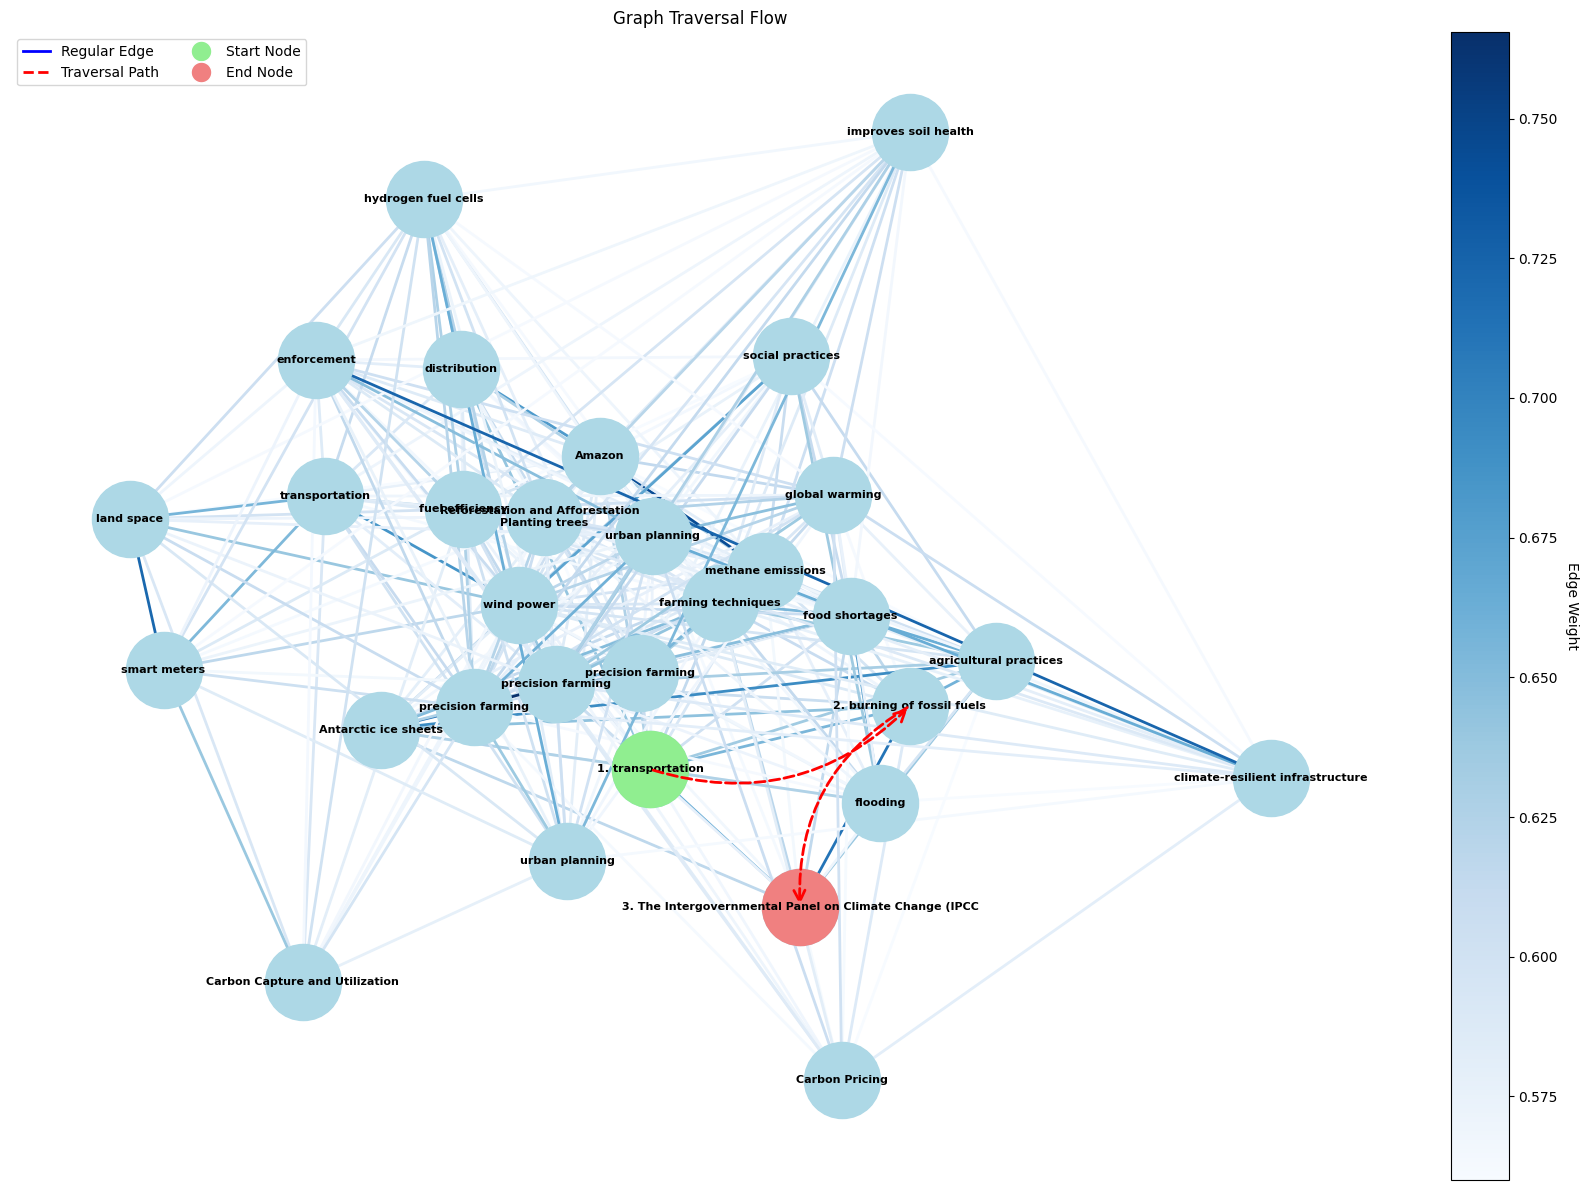

In [74]:
query = "what is the main cause of climate change?"
response = graph_rag.query(query)